In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-10-29 18:51:31.112540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 18:51:32.030174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 160
learning_rate = 1e-3
batch_per_file_size = 8
decay_rate = 0.95
node_embedding_size = 12
layers = [32, 12, 32, 8]

dataset = LayoutDataset(
    batch_size, train_sample_fraction=1.0,
    subset=None, build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-10-29 18:51:34.482440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 18:51:34.581353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 18:51:34.581796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    decay_rate=decay_rate,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    l1_multiplier=1e-9,
    n_siblings=dataset.n_siblings
)

In [4]:
mlp.train(dataset, None)

2023-10-29 18:53:39.662544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-29 18:53:39.704363: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f78bef25470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 18:53:39.704392: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-10-29 18:53:39.725687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 18:53:39.945379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-29 18:53:40.087675: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.2742572 lr 0.00005
iteration 1000 training loss 2.8619025 lr 0.00010
iteration 1500 training loss 2.8043482 lr 0.00015
iteration 2000 training loss 2.6986086 lr 0.00020
iteration 2500 training loss 2.4111965 lr 0.00025
iteration 3000 training loss 2.515204 lr 0.00030
iteration 3500 training loss 2.3285604 lr 0.00035
iteration 4000 training loss 2.7195592 lr 0.00040
iteration 4500 training loss 2.3141649 lr 0.00045
iteration 5000 training loss 2.227578 lr 0.00050
iteration 5500 training loss 1.7654948 lr 0.00055
iteration 6000 training loss 1.9771751 lr 0.00060
iteration 6500 training loss 2.4240117 lr 0.00065
iteration 7000 training loss 1.7555562 lr 0.00070
iteration 7500 training loss 1.9132864 lr 0.00075
iteration 8000 training loss 1.8289745 lr 0.00080
iteration 8500 training loss 2.027292 lr 0.00085
iteration 9000 training loss 2.264905 lr 0.00090
iteration 9500 training loss 2.2980735 lr 0.00095
iteration 10000 training loss 1.6682835 lr 0.00100
layo

iteration 70000 training loss 1.3831978 lr 0.00087
layout:nlp:random 0.8960743698186638
layout:nlp:default 0.4726658025278139
layout:xla:random 0.6264391375488888
layout:xla:default 0.2828718980814362
epoch 0, it 70000 validation loss -0.570
iteration 70500 training loss 0.9984769 lr 0.00086
iteration 71000 training loss 1.5602082 lr 0.00086
iteration 71500 training loss 1.2282087 lr 0.00086
iteration 72000 training loss 0.92454267 lr 0.00086
iteration 72500 training loss 1.1885288 lr 0.00086
iteration 73000 training loss 1.622012 lr 0.00085
iteration 73500 training loss 1.3328279 lr 0.00085
iteration 74000 training loss 1.685357 lr 0.00085
iteration 74500 training loss 1.3667822 lr 0.00085
iteration 75000 training loss 1.3446996 lr 0.00084
iteration 75500 training loss 1.1004361 lr 0.00084
iteration 76000 training loss 1.8338332 lr 0.00084
iteration 76500 training loss 1.4201447 lr 0.00084
iteration 77000 training loss 1.1619002 lr 0.00083
iteration 77500 training loss 1.3098261 lr 0.

## Evaluate validation set

In [5]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

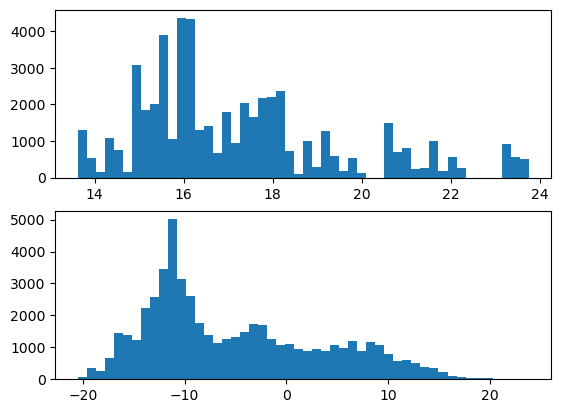

In [6]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [7]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:nlp:random:talking-heads_large_batch_size_16_train',b'layout:nlp:random:talking-heads_large_batch_...,8,-20.485592,18.728615
b'layout:nlp:default:talking-heads_large_batch_size_16_train',b'layout:nlp:default:talking-heads_large_batch...,1,-20.151482,18.689413
b'layout:nlp:random:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:random:small_bert_bert_en_uncased...,45,-19.720299,18.142046
b'layout:nlp:random:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:random:bert_multi_cased_L-12_H-76...,50,-19.165131,17.404604
b'layout:nlp:random:albert_en_xlarge_batch_size_16_test',b'layout:nlp:random:albert_en_xlarge_batch_siz...,1,-19.038651,17.862768
b'layout:nlp:random:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_16_train',b'layout:nlp:random:small_bert_bert_en_uncased...,15,-18.828897,17.054642
b'layout:nlp:default:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,10,-17.621593,18.141766
b'layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:default:bert_multi_cased_L-12_H-7...,46,-17.525675,17.403856
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_16_train',b'layout:nlp:default:small_bert_bert_en_uncase...,61,-17.172775,17.053982


Text(0.5, 1.0, "b'layout:nlp:random:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_32_train'")

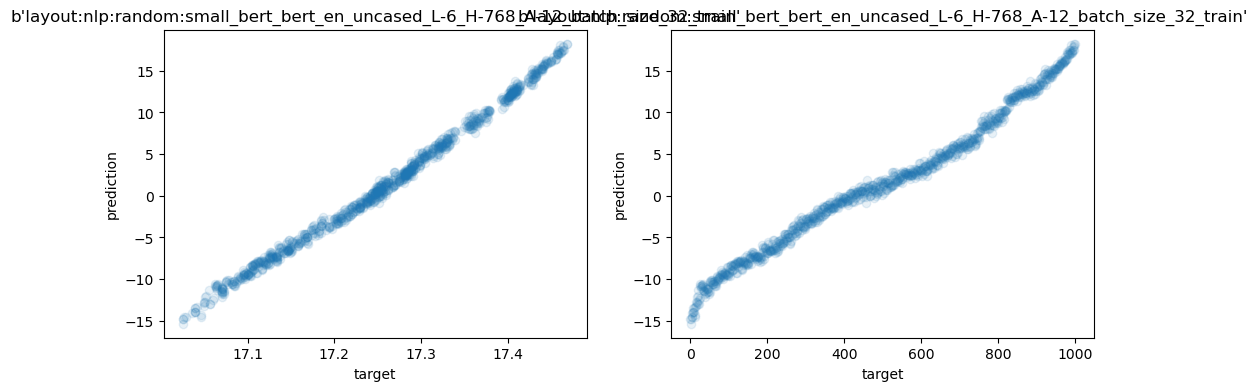

In [32]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

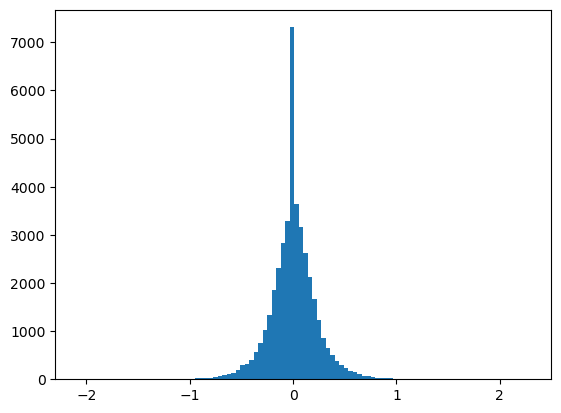

In [9]:
plt.hist(mlp.k_layer.kernel.numpy().flatten(), bins=100);

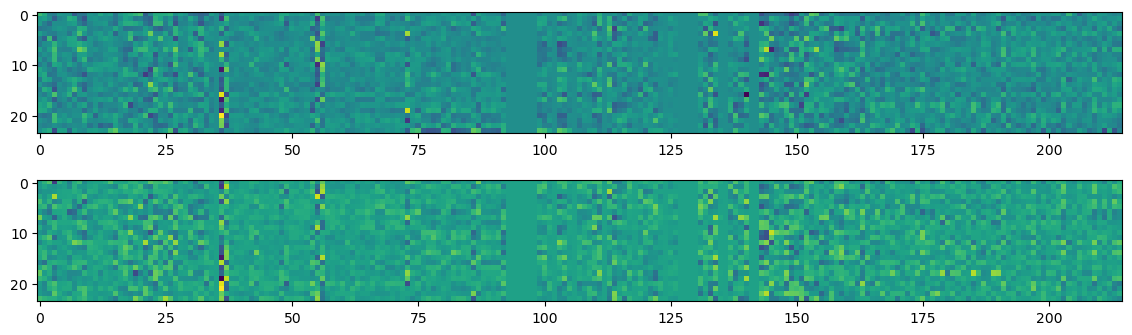

In [34]:
plt.figure(figsize=(14, 4))
kind = 1
plt.subplot(2, 1, 1)
k_vals = mlp.k_layer.kernel.numpy().reshape(215, 8, -1)[:, kind, :].T
plt.imshow(k_vals)

plt.subplot(2, 1, 2)
q_vals = mlp.q_layer.kernel.numpy().reshape(215, 8, -1)[:, kind, :].T
plt.imshow(q_vals)

00        interesting features (20)
            np.arange(21, 27),  # shape dims
            np.arange(31, 37),  # reshape/broadcast dims
            np.arange(95, 99),  # conv dims input
            np.arange(101, 105),  # conv dims kernel
20        parent output shapes (12)
32        sibling shapes (n_siblings*6)
50        physical layout (6)
56        node layout (18)
74        parent phys layout (12)
86        siblings layout (n_sibling*18)
140        parent opcodes (2)
164        sibling opcodes (n_siblings)
200        opcode (1)

In [ ]:
lens = [20, 12, 18, 6, 18, 12, 18*3, 24, 36, 12]
np.cumsum(lens)

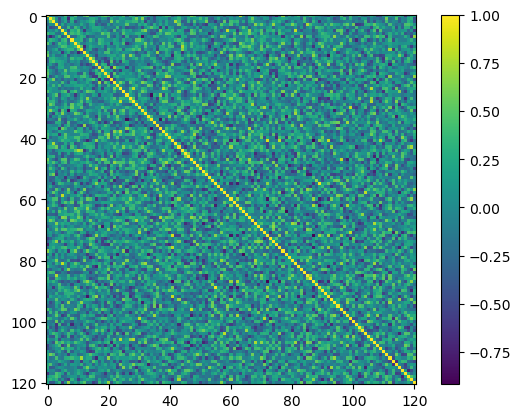

In [35]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
dots[34, 26]

In [ ]:
np.argsort(dots[26])

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

In [36]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

,ID,config_index,prediction,target
34036,b'layout:xla:default:unet_3d.4x4.bf16',1098,6.206957,20.629896
38682,b'layout:xla:default:unet_3d.4x4.bf16',1787,8.542301,20.629900
38664,b'layout:xla:default:unet_3d.4x4.bf16',1787,8.542301,20.629900
38339,b'layout:xla:default:unet_3d.4x4.bf16',1154,6.603059,20.629902
39720,b'layout:xla:default:unet_3d.4x4.bf16',1683,6.073259,20.629904
...,...,...,...,...
33838,b'layout:xla:default:unet_3d.4x4.bf16',702,6.917514,20.646017
38977,b'layout:xla:default:unet_3d.4x4.bf16',409,8.813030,20.646019
37852,b'layout:xla:default:unet_3d.4x4.bf16',1568,8.336096,20.646027
39339,b'layout:xla:default:unet_3d.4x4.bf16',1568,8.336096,20.646027


In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
layout_ids = val_batch['layout_id']
config_descriptor = val_batch['node_descriptor']
valid_mask = val_batch['valid_nodes']
graph_descriptor = val_batch['graph_descriptor']

with tf.device('/cpu:0'):
    subset_info_str = tf.map_fn(
        lambda layout_id: tf.strings.reduce_join(
            tf.strings.split(layout_id, ":")[:3]),
        layout_ids
    )

subset_info = mlp.text_vectorization(subset_info_str)
subset_info = tf.expand_dims(subset_info, axis=-1)
subset_info = mlp.embedding_layer_subset_info(subset_info)
subset_info = subset_info[:, 0, :]

# for si, sn in zip(subset_info_str.numpy(), subset_info.numpy()):
#     print(si, sn)

node_operations = config_descriptor[:, :, -1]
config_descriptor = config_descriptor[:, :, :-1]
node_operations = tf.cast(node_operations, tf.int32)
# node_operations.shape == (batch_size, mask_max_len)                                                                                                                                 
node_embedding = mlp.embedding_layer_node_ops(node_operations)
# node_embedding.shape == (batch_size, mask_max_len, embed_len)
# np.unique(node_operations.numpy().flatten(), return_counts=True)

x = mlp.normalization_layer_config_nodes(config_descriptor)
normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, node_embedding], axis=-1)

x = mlp.dense_layer_node_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           
x = mlp.dense_layer_node_2(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           

# plt.hist(x.numpy().flatten(), bins=100);
float_mask = tf.sequence_mask(valid_mask, mlp.mask_max_len, dtype=tf.float32)
# (batch_size, n_config_nodes_upper_limit)                                                                                                                                            

float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask

x = tf.reduce_sum(x, axis=1)
#plt.subplot(2, 1, 1)
#plt.hist(x.numpy().flatten(), bins=100);

x = x / tf.expand_dims(tf.cast(valid_mask, tf.float32), axis=-1)
#plt.subplot(2, 1, 2)
#plt.hist(x.numpy().flatten(), bins=100);
for i, lid, gd, nd in zip(range(96), layout_ids.numpy(), graph_descriptor.numpy(), normal_graph_descriptor.numpy()):
    if i in [19]:
        print(i, gd[80:90], nd[80:90], lid)
x = tf.concat([x, normal_graph_descriptor, subset_info], axis=-1)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_1(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_2(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [37]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               29193;38179;27096;10250;10262;34025;34013;7186...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  47238;4779;41512;28828;64931;47265;63347;26478...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              22819;7806;22961;7815;11151;11525;11308;22896;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      56476;13143;82330;51719;75855;37169;55557;5359...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     47388;13350;25963;16292;13307;4090;206;25958;4...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      59186;48984;5693;29923;7639;25647;6339;39458;7...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     1199;306;367;331;357;515;548;27282;26576;329;5...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [38]:
val_df

,ID,config_index,prediction,target
0,b'layout:nlp:default:small_bert_bert_en_uncase...,75513,-6.280241,16.028984
1,b'layout:nlp:default:small_bert_bert_en_uncase...,66898,-11.554049,15.974212
2,b'layout:nlp:default:small_bert_bert_en_uncase...,9401,-12.504125,15.973986
3,b'layout:nlp:default:small_bert_bert_en_uncase...,47479,-12.482059,15.973673
4,b'layout:nlp:default:small_bert_bert_en_uncase...,43806,-5.424082,16.063269
...,...,...,...,...
53476,b'layout:nlp:default:albert_en_xlarge_batch_si...,4624,-13.640968,17.862844
53477,b'layout:nlp:default:albert_en_xlarge_batch_si...,10556,-13.324834,17.865395
53478,b'layout:nlp:default:albert_en_xlarge_batch_si...,19394,-13.338983,17.862881
53479,b'layout:nlp:default:albert_en_xlarge_batch_si...,13624,-13.186774,17.862776


In [39]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:nlp:default', 'layout:xla:random', 'layout:xla:default',
       'layout:nlp:random'], dtype=object)

In [40]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

layout:nlp:default 0.4771765941370001
layout:xla:random 0.59472832700049
layout:xla:default 0.28263743731795515
layout:nlp:random 0.8789638856381901


In [41]:
np.mean([0.4185, 0.8167, 0.538, 0.2525])

0.506425

In [42]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:random:unet_3d.4x4.bf16'                                                  -0.180565
b'layout:xla:default:unet_3d.4x4.bf16'                                                 -0.008526
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.119070
b'layout:xla:default:bert_pretraining.4x4.fp16'                                         0.316147
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.340279
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train'     0.343605
b'layout:xla:default:inception_v3_batch_128_train'                                      0.344017
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train'     0.356793
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.369610
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.377321
b'layout:xla:random:mlperf_

In [43]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [44]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:default:32531d07a084b319dce484f53...,9,-14.036493
1,b'layout:nlp:default:32531d07a084b319dce484f53...,20,-13.062977
2,b'layout:nlp:default:32531d07a084b319dce484f53...,18,-13.105321
3,b'layout:xla:default:3e7156ac468dfb75cf5c9615e...,8,-7.021866
4,b'layout:xla:default:3e7156ac468dfb75cf5c9615e...,13,-6.513423
...,...,...,...
49997,b'layout:nlp:default:7f6284ebe027b1e9a3850fc70...,998,-11.627373
49998,b'layout:nlp:default:7f6284ebe027b1e9a3850fc70...,968,-12.748228
49999,b'layout:nlp:default:7f6284ebe027b1e9a3850fc70...,953,-12.729181
50000,b'layout:nlp:default:7f6284ebe027b1e9a3850fc70...,964,-11.672804


In [45]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    632;620;19;43;351;767;499;413;442;682;183;950;...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    41;386;149;472;132;252;855;919;794;510;470;325...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    463;779;669;176;715;993;93;417;75;621;215;801;...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    134;286;191;34;196;498;733;954;677;231;974;886...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    372;935;313;630;990;638;840;240;483;109;804;46...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    614;165;284;93;618;439;901;224;822;162;159;713...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    5;413;948;221;986;339;803;634;524;40;883;563;4...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    969;69;111;442;796;755;4;693;72;684;748;486;75...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    166;559;830;786;851;478;748;693;452;584;131;17...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [46]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_none_test_prediction_10_30_00_28.csv')